# Optimización: Tarea 5
## Oscar Esaú Peralta Rosales

In [0]:
import time

from typing import Callable, Dict, Tuple
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import ldl


## Funciones

### Rosembrock

In [0]:
def f2(x :np.array, n :int=100) -> float:
    """ Compute the evaluation for Extended Rosembrock function with n=100
        Args:
        x: Array of length=n with x's parameters
        n: Rosembrock, n = 100
        
        Returns:
            Evaluation of f(X)
    """
    ans = 0.0
    for i in range(n-1):
        ans += 100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2
    return ans


def f2_grad(x :np.array, n :int=100) -> np.array:
    """ Compute the gradient evaluation for Extended Rosembrock function with n=2 
        Args:
        x: Array of length=n with x's parameters
        n: Rosembrock, n = 100
        
        Returns:
            Gradient of f(x1, ..., xn), array with lenght=n
    """
    # grad = np.zeros(n, dtype=np.float64)
    # for i in range(n-1):
    #     grad[i] = -400 * x[i+1] * x[i] + 400 * x[i]**3 + 2 * x[i] -2
    # grad[n-1] = 200 * (x[n-1] - x[n-2]**2)
    # return grad
    grad=np.array([-400*(x[1]-x[0]**2)*x[0]-2*(1-x[0])])
    
    for i in range(1, n-1): 
        grad=np.append(grad,[200*(x[i]-x[i-1]**2)-400*(x[i+1]-x[i]**2)*x[i]-2*(1-x[i])])
    
    grad=np.append(grad,[200*(x[99] - x[98]**2)])
    
    return grad


def f2_hess(x :np.array, n :int=100) -> np.array:
    """ Compute the Hessian evaluation for Extended Rosembrock function with n=2 
        Args:
        x: Array of length=n with x's parameters
        
        Returns:
            Hessian of f(x1, ..., xn), Matrix with size=nxn
    """
    hess = np.zeros((n, n), dtype=np.float64)
    for i in range(n-1):
            hess[i][i] = -400 * x[i+1] + 1200 * x[i]**2 + 2
            hess[i][i] += 200 if i != 0 else 0
            hess[i][i+1] = hess[i+1][i] = -400 * x[i]
    hess[n-1][n-1] = 200.0
    return hess



### Wood

In [0]:
def f3(x :np.array) -> float:
    """ Compute the evaluation for Wood Function function with n=100
        Args:
        x: Array of length=4 with x's parameters
        
        Returns:
            Evaluation of f(X)
    """
    f1 = 100*(x[0]**2 - x[1])**2 + (x[0]-1)**2 + 10.1*(x[1]-1)**2 + (x[2]-1)**2 
    f2 = 10.1*(x[3]-1)**2 + 90*(x[2]**2-x[3])**2 +19.8*(x[1]-1)*(x[3]-1)
    return f1 + f2
    # ans = 100 * (x[0]**2 - x[1]) + (x[0] - 1)**2 + (x[2] - 1)**2 + 90 * (x[2]**2 - x[3])**2
    # ans += 10.1 * ((x[1] - 1)**2 + (x[3] - 1)**2) + 19.8 * (x[1] - 1) * (x[3] - 1)
    # return ans


def f3_grad(x :np.array) -> np.array:
    """ Compute the gradient evaluation for Extended Rosembrock function with n=2 
        Args:
        x: Array of length=4 with x's parameters
        
        Returns:
            Gradient of f(x1, x2, x3, x4), array with lenght=4
    """
    grad = np.zeros(4, dtype=np.float64)
    grad[0] = 400 * x[0]**3 - 400 * x[0] * x[1] + 2 * x[0] - 2
    grad[1] = -200 * (x[0]**2 - x[1]) + 20.2 * (x[1] - 1) + 19.8 * x[3] - 19.8
    grad[2] = 2 * x[2] - 2 + 360 * x[2]**3 - 360 * x[3] * x[2]
    grad[3] = -180 * (x[2]**2 - x[3]) + 20.2 * (x[3] - 1) + 19.8 * (x[1] -1)
    return grad


def f3_hess(x :np.array) -> np.array:
    """ Compute the Hessian evaluation for Extended Rosembrock function with n=2 
        Args:
        x: Array of length=4 with x's parameters
        
        Returns:
            Hessian of f(x1, x2, x3, x4), Matrix with size=4x4
    """
    hess = np.zeros((4, 4), dtype=np.float64)
    
    hess[0][0] = 1200 * x[0]**2 - 400 * x[1] + 2
    hess[0][1] = hess[1][0] = -400 * x[0]
    hess[1][1] = 220.2
    hess[2][2] = 1080 * x[2]**2 - 360 * x[3] + 2
    hess[3][1] = hess[1][3] = 19.8
    hess[3][2] = hess[2][3] = -360 * x[2]
    hess[3][3] = 200.2
    
    return hess

## Dogleg method

In [0]:
 # Stop criterias
stop_x = lambda x_k, x_k_next: np.linalg.norm(x_k_next - x_k) / max(np.linalg.norm(x_k), 1.0)
stop_f = lambda f_x_k, f_x_k_next: np.abs(f_x_k_next - f_x_k) / max(np.abs(f_x_k), 1.0)
stop_g = lambda grad_k: np.linalg.norm(grad_k)


def dogleg( X: np.array,
            f: Callable[[np.array], np.array],
            g: Callable[[np.array], np.array],
            H: Callable[[np.array], np.array],
            tol_x: float=1e-12,
            tol_g: float=1e-12,
            tol_f: float=1e-12,
            mxitr: int=100,
            **kwargs):
    Result = namedtuple('Result', 'x_log f_log g_norm_log')

    # History of values computed

    x_log = []
    f_log = []
    g_norm_log = []

    x_k_prev = None;
    x_k = X;
    x_log.append(x_k)

    f_k = f(x_k, **kwargs.get('f_kwargs', {}))
    f_log.append(f_k)

    g_k_prev = None
    g_k = g(x_k)
    g_norm_log.append(np.linalg.norm(g_k))

    b_k = H(x_k, **kwargs.get('H_kwargs', {}))

    delta_k = kwargs.get('delta', 1e-2)
    delta_max = kwargs.get('delta_max', 1e-2)
    eta = kwargs.get('eta', 0.25)

    k = 0
    alpha_k = kwargs.get('alpha', 1e-2)

    while np.linalg.norm(g_k) > tol_g and k < mxitr:
        # compute p_k
        p_ku = - g_k.dot(g_k) / (g_k @ b_k @ g_k) * g_k
        p_kb = - np.linalg.inv(b_k) @ g_k

        if np.linalg.norm(p_kb) <= np.linalg.norm(delta_k):
            p_k = p_kb # optimal p_k
        else:
            # Find tau that interset with the confidence region
            if np.linalg.norm(p_ku) >= delta_k:
                # Intersection with p_ku
                tau_k = delta_k / np.linalg.norm(p_ku) 
            else:
                # Intersection with p_kb
                a = np.linalg.norm(p_kb - p_ku) ** 2
                b = 2 * p_kb.dot(p_kb - p_ku)
                c = np.linalg.norm(p_ku)**2 - delta_k**2

                lambda_k = (-b + np.sqrt(b**2 - 4*a*c)) / (2*a), (-b - np.sqrt(b**2 - 4*a*c)) / (2*a)
                tau_k = lambda_k[0] + 1, lambda_k[1] + 1
                tau_k = tau_k[0] if tau_k[0] >= 1 and tau_k[0] <= 2.0 else tau_k[1]

            if 0 <= tau_k and tau_k <= 1.0:
                p_k = tau_k * p_ku
            elif 1.0 < tau_k and tau_k <= 2.0:
                p_k = p_ku + (tau_k - 1.0) * (p_kb - p_ku)
            else:
                pass
        
        # Compute ro_k to increase o decrease the confidence region
        m_kp = f_k + g_k.dot(p_k)
        ro_k = (f_k - f(x_k + p_k)) / (f_k - m_kp)

        if ro_k < 0.25:
            delta_k = 0.25 * delta_k
        else:
            if ro_k > 0.75 and np.linalg.norm(p_k) == delta_k:
                delta_k = min(2.0 * delta_k, delta_max)
            else:
                pass

        if ro_k <= eta:
            continue
        
        # Update x
        x_k_prev = x_k
        x_k = x_k_prev + p_k
        x_log.append(x_k)

        f_k = f(x_k, **kwargs.get('f_kwargs', {}))
        f_log.append(f_k)

        g_k_prev = g_k
        g_k = g(x_k, **kwargs.get('g_kwargs', {}))
        g_norm_log.append(np.linalg.norm(g_k))

        b_k = H(x_k, **kwargs.get('H_kwargs', {}))

        # Stop criteria
        if stop_x(x_log[-2], x_log[-1]) <= tol_x or stop_f(f_log[-2], f_log[-1]) <= tol_f:
            break

        k += 1

    return Result(np.array(x_log), np.array(f_log), np.array(g_norm_log))


iters: 61
g norm 9.998663745839284486
f error 3.9866238543009337423


array([-0.9932861 ,  0.99665107,  0.99833032,  0.99916774,  0.9995852 ,
        0.99979328,  0.99989698,  0.99994866,  0.99997441,  0.99998725,
        0.99999365,  0.99999683,  0.99999842,  0.99999921,  0.99999961,
        0.9999998 ,  0.9999999 ,  0.99999995,  0.99999998,  0.99999999,
        0.99999999,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

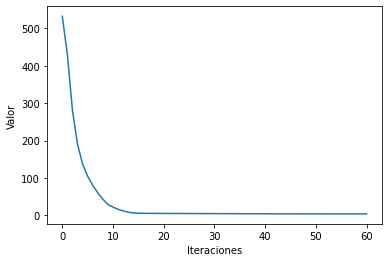

In [5]:
X = np.ones(100, dtype=np.float128)
X[0] = X[-2] = -1.2

xop = np.ones(100)

params = {
    'X': X,
    'f': f2,
    'g': f2_grad,
    'H': f2_hess,
    'tol_x': 1e-12,
    'tol_f': 1e-12,
    'tol_g': 1e-12,
    'mxitr': 10000,
    'delta': 0.1,
    'delta_max': 0.2,
    'eta': 0.1
}

ans = dogleg(**params)

print("iters: %d" % len(ans.x_log))
print("g norm", np.linalg.norm(ans.x_log[-1]))
print("f error", ans.f_log[-1] - f2(xop))

# plt.plot(ans.g_norm_log)
plt.plot(ans.f_log)
plt.xlabel('Iteraciones')
plt.ylabel('Valor')
ans.x_log[-1]

iters: 44
g norm 1.9180407354113666708
f error 7.8769671651768674537


array([-0.96797402,  0.94713914, -0.96951631,  0.95124767], dtype=float128)

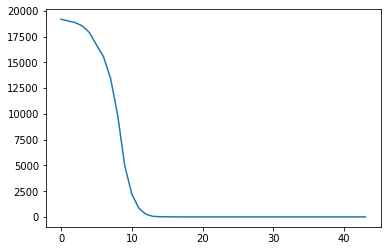

In [6]:
X = np.array([-3, -1, -3, -1], dtype=np.float128)
xop = np.ones(4)

params = {
    'X': X,
    'f': f3,
    'g': f3_grad,
    'H': f3_hess,
    'tol_x': 1e-12,
    'tol_f': 1e-12,
    'tol_g': 1e-12,
    'mxitr': 10000,
    'alpha': 1e-2,
    'delta': 0.01,
    'delta_max': 1,
    'eta': 0.01
}

ans = dogleg(**params)

print("iters: %d" % len(ans.x_log))
print("g norm", np.linalg.norm(ans.x_log[-1]))
print("f error", ans.f_log[-1] - f3(xop))

# plt.plot(ans.g_norm_log)
plt.plot(ans.f_log)
ans.x_log[-1]

In [7]:
# X = np.ones(100, dtype=np.float64)
# X[0] = X[-2] = -1.2


X = np.array([-3, -1, -3, -1], dtype=np.float64)

f3_hess(X)

array([[11202. ,  1200. ,     0. ,     0. ],
       [ 1200. ,   220.2,     0. ,    19.8],
       [    0. ,     0. , 10082. ,  1080. ],
       [    0. ,    19.8,  1080. ,   200.2]])